# Prophet Model Development

FBProphet uses a combination of regression models and Bayesian inference to model time series data. it allows the flexibility to model complicated time series features by fitting trends and multiple seasonalities to incorporate yearly, monthly, weekly and daily pattens along with holiday effects.

FBProphet also allows for the inclusion of additional regressors in the model. Regressors are external variables that may influence the time series, such as holidays, weather patterns, or marketing campaigns. Including regressors in the model can improve the accuracy of the forecasts by capturing the effects of these external variables on the time series.

In [2]:
# import required libraries
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Import the clean Merged Dataset (Natural Gas demand and Weather factors)
This dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023.

In [65]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


## Step 2 : Data Preparation for Modelling 
For this step, we are preparing the series Cross-validation evaluation method

In [5]:
# Prepare this dataset for cross-validation prophet modelling 
merged_df_mod = merged_df.copy()
merged_df_mod.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

In [6]:
# Split the data into training set from 2013-11-01 to 2021-10-31, and using 2021-11-01 to 2023-10-31 as test/validation set
train_df = merged_df[merged_df['DATE'] < '2021-12-01']
validation_df = merged_df[merged_df['DATE'] >= '2021-12-01']

# Print the shape of the train-test split
print(train_df.shape)
print(validation_df.shape)

(2952, 12)
(700, 12)


## Step 3: Model Development
In this step, the model development include a base Prophet model using the train-test split method and cross-validation. Then the better performed model is further turnd to refined the model performance.

### 1. Prophet Base Model 
**Creating and Forecasting with Prophet**

In [8]:
# Let's do the transformation required for using fbProphet in the train dataset: columns ds (Date) and y (value)
train_df1 = train_df.copy()
train_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

# Let's do the transformation required for using fbProphet in validation dataset: columns ds (Date) and y (value)
test_df1 = validation_df.copy()
test_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

12:46:51 - cmdstanpy - INFO - Chain [1] start processing
12:46:53 - cmdstanpy - INFO - Chain [1] done processing


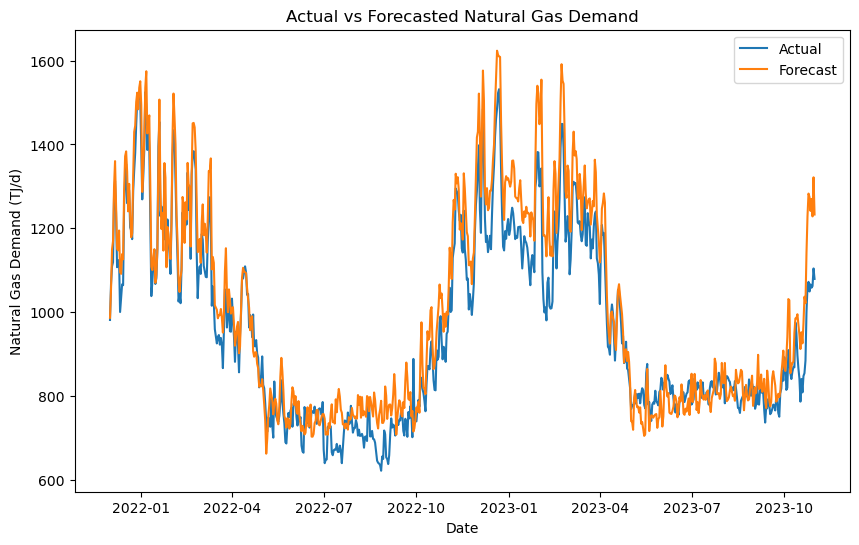

In [14]:
# Importing the necessary libraries and modules
from sklearn.base import BaseEstimator, RegressorMixin
from prophet import Prophet
import matplotlib.pyplot as plt

# Defining a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a Prophet model with the given parameters
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Adding additional regressors to the model
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fitting the model to the data
        self.model.fit(X)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Instantiating the ProphetWrapper class
model = ProphetWrapper()

# Fitting the model to the training data
model.fit(train_df1)

# Generating predictions on the test data
forecast1 = model.predict(test_df1)

# Convert 'ds' to datetime
test_df1['ds'] = pd.to_datetime(test_df1['ds'])
forecast1['ds'] = pd.to_datetime(forecast1['ds'])

# Plot the actual and forecasted 'NG_DEMAND'
plt.figure(figsize=(10, 6))
plt.plot(test_df1['ds'], test_df1['y'], label='Actual')
plt.plot(forecast1['ds'], forecast1['yhat'], label='Forecast')
plt.title('Actual vs Forecasted Natural Gas Demand')
plt.xlabel('Date')
plt.ylabel('Natural Gas Demand (TJ/d)')
plt.legend()
plt.show()

**Performance Metrics**

In [26]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_true is the actual values and y_pred is the predicted values
y_true = test_df1['y']
y_pred = forecast1['yhat']

mse = mean_squared_error(y_true, y_pred)     # Calculate Mean Squared Error (MSE)
rmse = np.sqrt(mse)     # Calculate Root Mean Squared Error (RMSE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100     # Calculate Mean Absolute Percentage Error (MAPE)
mae = mean_absolute_error(y_true, y_pred)     # Calculate Mean Absolute Error (MAE)
mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100       # Calculate Median Absolute Percentage Error (MDAPE)
r2 = r2_score(y_true, y_pred)     # Calculate R squared

# Print the performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")
print(f"MDAPE: {mdape}%")
print(f"R squared: {r2}")

MSE: 5597.74485265844
RMSE: 74.8180783812204
MAPE: nan%
MAE: 59.916125022741866
MDAPE: nan%
R squared: 0.8844150706751865


### 2. Prophet with Cross-Validation
- This dataset has 10 years (3651 days) of daily sales data. The initial parameter is set to ‘1825 days’, which means the initial training period consists of the first five years of data.
- The period parameter is set to ‘365 days’, which indicates that the cross-validation will be performed every 365 days (approximately every year). The horizon parameter is set to ‘365 days’, meaning that each cross-validation step will generate forecasts for the next 365 days (1 year).

**Building the Model**

In [16]:
# Importing the necessary libraries and modules
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics

In [17]:
# Define a wrapper for the Prophet model to use with sklearn
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Instantiate and fit the model
model = ProphetWrapper()
model.fit(merged_df_mod)

# Perform cross-validation
df_cv = cross_validation(model.model, initial='1825 days', period='365 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▊                                                                   | 1/5 [00:02<00:08,  2.13s/it]13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████████████████████▌                                                  | 2/5 [00:05<00:07,  2.63s/it]13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:07<00:04,  2.49s/it]13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmds

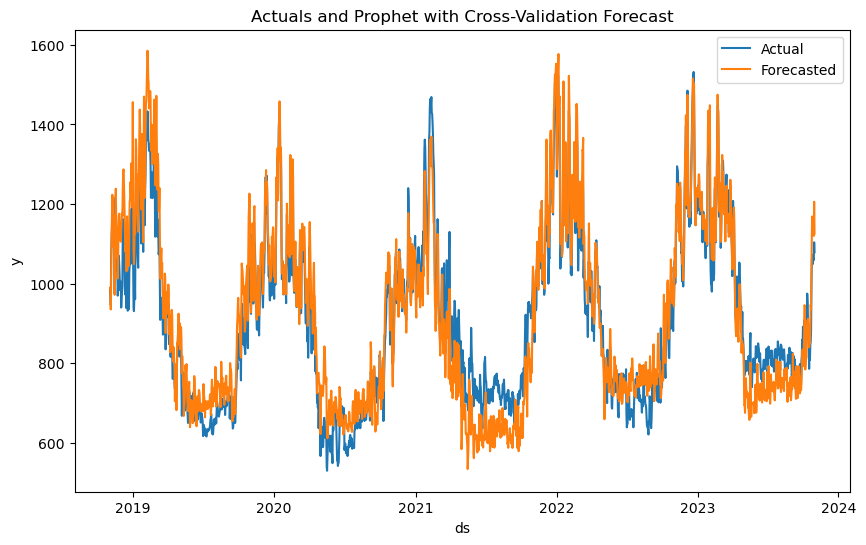

In [33]:
# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

**Performance Metrics**

In [19]:
# Calculate MAE, MSE, and RMSE
mae_cv = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse_cv = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse_cv = np.sqrt(mse)
r2_cv = r2_score(df_cv['y'], df_cv['yhat'])
mape_cv = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100
mdape_cv = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

print(f'Mean Absolute Error: {mae_cv:.2f}')
print(f'Mean Squared Error: {mse_cv:.2f}')
print(f'Root Mean Squared Error: {rmse_cv:.2f}')
print(f'R-squared: {r2_cv:.2f}')
print(f'Mean Absolute Percentage Error: {mape_cv:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_cv:.2f}%')

Mean Absolute Error: 60.01
Mean Squared Error: 5411.37
Root Mean Squared Error: 73.56
R-squared: 0.88
Mean Absolute Percentage Error: 7.03%
Median Absolute Percentage Error: 5.84%


## Step 4: Hyperparameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Define parameter grid
param_grid = {'interval_width': [0.8, 0.9], 'yearly_seasonality': [True, False], 'seasonality_mode': ['additive', 'multiplicative']}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid.fit(merged_df_mod)

# Print best parameters
print(f'Best Parameters: {grid.best_params_}')

# Perform cross-validation with the best model
df_cv2 = cross_validation(grid.best_estimator_.model, initial='1825 days', period='365 days', horizon='365 days')

# Calculate performance metrics
df_metrics4 = performance_metrics(df_cv2)

23:58:53 - cmdstanpy - INFO - Chain [1] start processing
23:58:57 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'interval_width': 0.8, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]23:58:58 - cmdstanpy - INFO - Chain [1] start processing
23:58:59 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.87s/it]23:59:00 - cmdstanpy - INFO - Chain [1] start processing
23:59:01 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.19s/it]23:59:02 - cmdstanpy - INFO - Chain [1] start processing
23:59:04 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.35s/it]23:59:05 - cmdstanpy - INFO - Chain [1] start processing
23:59:08 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████████████████████████████████████████████████████████████████

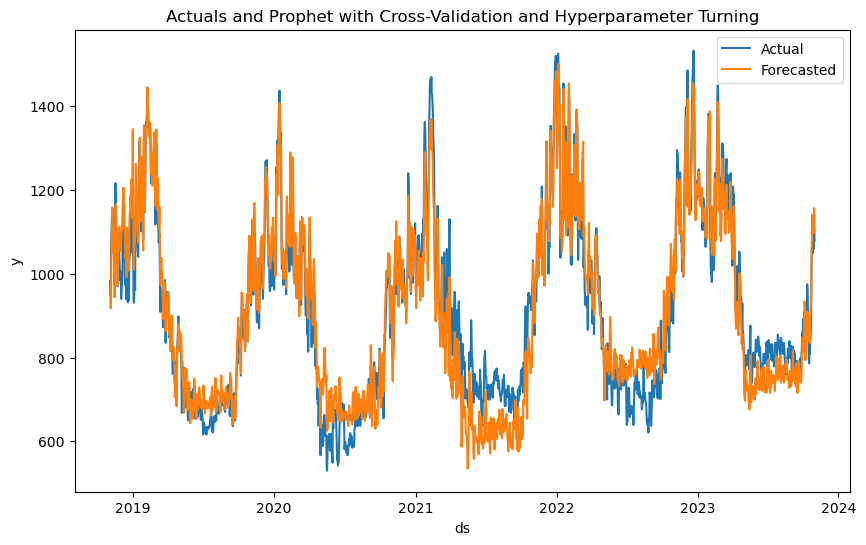

In [35]:
# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv2['ds'], df_cv2['y'], label='Actual')
plt.plot(df_cv2['ds'], df_cv2['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Turning')
plt.show()

- **Performance Metrics**

In [36]:
# Calculate MAE, MSE, RMSE, and R-squared
mae_hy = mean_absolute_error(df_cv2['y'], df_cv2['yhat'])
mse_hy = mean_squared_error(df_cv2['y'], df_cv2['yhat'])
rmse_hy = np.sqrt(mse)
r2_hy = r2_score(df_cv2['y'], df_cv2['yhat'])
mape_hy = np.mean(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100
mdape_hy = np.median(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100

print(f'Mean Absolute Error: {mae_hy:.2f}')
print(f'Mean Squared Error: {mse_hy:.2f}')
print(f'Root Mean Squared Error: {rmse_hy:.2f}')
print(f'R-squared: {r2_hy:.2f}')
print(f'Mean Absolute Percentage Error: {mape_hy:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_hy:.2f}%')

Mean Absolute Error: 51.45
Mean Squared Error: 4219.16
Root Mean Squared Error: 74.82
R-squared: 0.91
Mean Absolute Percentage Error: 6.23%
Median Absolute Percentage Error: 4.65%


## Step 5: Model Evaluation


In [39]:
# Define the metrics for the model
metrics_base = [mse, rmse, mape, mae, mdape, r2]
metrics_cv = [mse_cv, rmse_cv, mape_cv, mae_cv, mdape_cv, r2_cv]
metrics_hy = [mse_hy, rmse_hy, mape_hy, mae_hy, mdape_hy, r2_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({'Base Model': metrics_base, 'Cross-Validation': metrics_cv, 'Improved-Prophet': metrics_hy}, index=labels)

df_metrics.head(10)

,Base Model,Cross-Validation,Improved-Prophet
MSE,5597.744853,5411.371846,4219.155854
RMSE,74.818078,73.562027,74.818078
MAPE,NaN,7.034190,6.234021
MAE,59.916125,60.008487,51.453191
MDAPE,NaN,5.835180,4.652606
R-squared,0.884415,0.881293,0.907446


- In summary, the Improved-Prophet model performs the best in terms of MSE, MAE, MAPE, MDAPE, and R-squared, which means using grid search, we fine fine-tune the model's hyperparameters to achieve better forecasting performance.
- The presence of NaN values in MAPE and MDAPE for the Base Model might indicate some issues with the predictions (like predicting zero values). It would be worth investigating this further.
- The Cross-Validation model performs slightly better in terms of RMSE. It’s important to consider all these metrics together when evaluating the performance of the models.r.

## SARIMA Model Development

In [46]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error

Mean Absolute Error: 86.72
Mean Squared Error: 11107.99
Root Mean Squared Error: 105.39
R-squared: 0.78
Mean Absolute Percentage Error: 10.94%
Median Absolute Error: 77.67


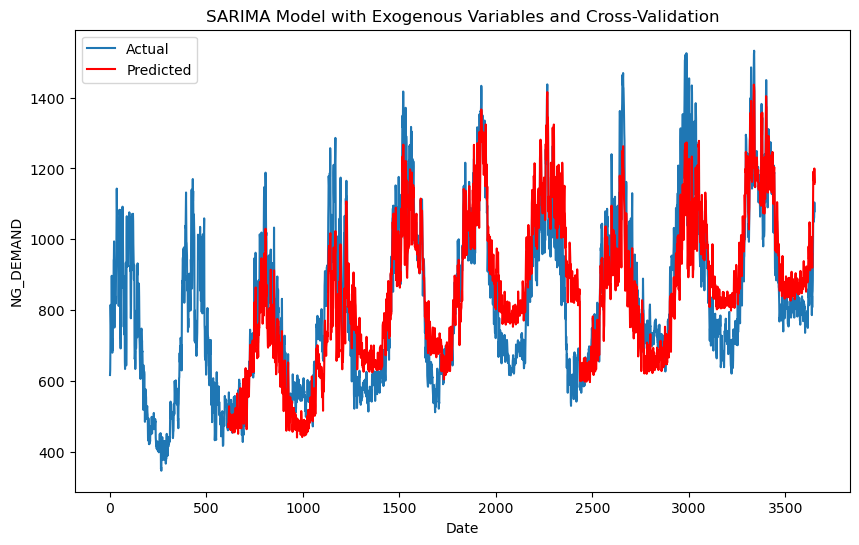

In [48]:
# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Define the SARIMA model order
order = (1, 1, 1)  # (p, d, q) non-seasonal part
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) seasonal part

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Lists to store the actual and predicted values
actual_values = []
predicted_values = []

# Perform cross-validation
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Fit SARIMA model with exogenous variables
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Ignore convergence warnings
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=True, maxiter=1000)  # Increase max iterations

    # Forecast future values
    forecast_steps = len(test_index)
    forecast = results.get_forecast(steps=forecast_steps, exog=X_test)

    # Store actual and predicted values
    actual_values.extend(y_test)
    predicted_values.extend(forecast.predicted_mean)

# Calculate and print additional performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
medae = median_absolute_error(actual_values, predicted_values)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')
print(f'Median Absolute Error: {medae:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(y.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
plt.title('SARIMA Model with Exogenous Variables and Cross-Validation')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()

In [50]:
from statsmodels.tsa.stattools import adfuller
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(merged_df['NG_DEMAND'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.650559
p-value                           0.004865
#Lags Used                       13.000000
Number of Observations Used    3638.000000
Critical Value (1%)              -3.432149
Critical Value (5%)              -2.862335
Critical Value (10%)             -2.567193
dtype: float64


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 66.733
R-squared (R2): 0.868
Mean Squared Error (MSE): 6406.119
Mean Absolute Percentage Error (MAPE): 7.832%
Median Absolute Percentage Error (MDAPE): 6.194%


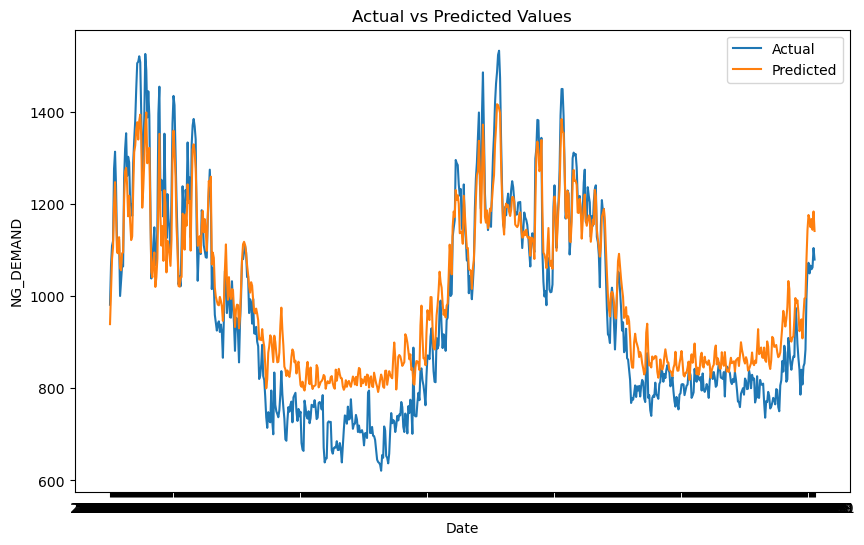

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from matplotlib import pyplot as plt

# Specify the target variable and features
target = 'NG_DEMAND'
features = merged_df.columns.drop([target, 'DATE'])

# Split the dataset into train and validation sets
train_df = merged_df[merged_df['DATE'] < '2021-12-01']
validation_df = merged_df[merged_df['DATE'] >= '2021-12-01']

# Fit the SARIMAX model
model = SARIMAX(train_df[target], exog=train_df[features], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions on the validation set
predictions = model_fit.predict(start=len(train_df), end=len(train_df)+len(validation_df)-1, exog=validation_df[features])

# Calculate the evaluation metrics
mae = mean_absolute_error(validation_df[target], predictions)
r2 = r2_score(validation_df[target], predictions)
mse = mean_squared_error(validation_df[target], predictions)
mape = np.mean(np.abs((validation_df[target] - predictions) / validation_df[target])) * 100
mdape = np.median(np.abs((validation_df[target] - predictions) / validation_df[target])) * 100

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R-squared (R2): {r2:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')
print(f'Median Absolute Percentage Error (MDAPE): {mdape:.3f}%')

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(validation_df['DATE'], validation_df[target], label='Actual')
plt.plot(validation_df['DATE'], predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()

In [88]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Custom wrapper for SARIMAX to use with sklearn
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=100, warn_convergence=False)  # Set warn_convergence to False
        return self

    def predict(self, X):
        return self.results.get_forecast(steps=X.shape[0], exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Define a pipeline combining feature selection and SARIMAX model
pipe = Pipeline([
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=100)

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Fit and search for the best parameters
    grid.fit(X_train, y_train)

    # Get the best model
    model = grid.best_estimator_

    # Forecast future values
    forecast_steps = len(y_test)  # Ensure we only forecast as many steps as there are in the test set
    forecast = model.predict(X_test[:forecast_steps])  # Use only as many exogenous variables as there are steps to forecast

    # Store actual and predicted values
    actual_values.extend(y_test)
    predicted_values.extend(forecast)

# Calculate and print additional performance metrics
mae_sa = mean_absolute_error(actual_values, predicted_values)
mse_sa = mean_squared_error(actual_values, predicted_values)
rmse_sa = np.sqrt(mse)
r2_sa = r2_score(actual_values, predicted_values)
mape_sa = mean_absolute_percentage_error(actual_values, predicted_values) * 100
medape_sa = (median_absolute_error(actual_values, predicted_values) / np.median(actual_values)) * 100

print(f'Mean Absolute Error: {mae_sa:.2f}')
print(f'Mean Squared Error: {mse_sa:.2f}')
print(f'Root Mean Squared Error: {rmse_sa:.2f}')
print(f'R-squared: {r2_sa:.2f}')
print(f'Mean Absolute Percentage Error: {mape_sa:.2f}%')
print(f'Median Absolute Percentage Error: {medape_sa:.2f}%')

# Plot the results
#plt.figure(figsize=(10, 6))
#plt.plot(merged_df.index[-len(predicted_values):], y[-len(predicted_values):], label='Actual')
#plt.plot(merged_df.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
#plt.title('SARIMA Model with Exogenous Variables, Cross-Validation, and Hyperparameter Tuning')
#plt.xlabel('Date')
#plt.ylabel('NG_DEMAND')
#plt.legend()
#plt.show()


Mean Absolute Error: 65.73
Mean Squared Error: 6629.96
Root Mean Squared Error: 89.23
R-squared: 0.87
Mean Absolute Percentage Error: 8.17%
Median Absolute Percentage Error: 7.08%


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Define the pipeline
def create_pipeline():
    # Column Transformer for feature scaling
    preprocess = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns),
        ],
        remainder='passthrough'
    )

    # LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', model)
    ])

    return pipeline

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Lists to store the actual and predicted values
actual_values = []
predicted_values = []

# Perform cross-validation
for train_index, test_index in tscv.split(y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Reshape the data for LSTM input
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    # Build and fit the pipeline
    pipeline = create_pipeline()
    pipeline.fit(X_train, y_train, model__epochs=50, model__batch_size=32, model__verbose=0)

    # Make predictions
    predictions = pipeline.predict(X_test)

    # Inverse transform the predictions to original scale
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Inverse transform the actual values to original scale
    actual_values.extend(y_test)
    
    # Store predicted values
    predicted_values.extend(predictions)

# Calculate and print Mean Squared Error (MSE)
mse_ls = mean_squared_error(actual_values, predicted_values)
mse_ls = mean_squared_error(actual_values, predicted_values)
rmse_ls = np.sqrt(mse)
r2_ls = r2_score(actual_values, predicted_values)
mape_ls = mean_absolute_percentage_error(actual_values, predicted_values) * 100


print(f'Mean Squared Error: {mse_ls}')
print(f'Mean Absolute Error: {mae_ls:.2f}')
print(f'Mean Squared Error: {mse_ls:.2f}')
print(f'Root Mean Squared Error: {rmse_ls:.2f}')
print(f'R-squared: {r2_ls:.2f}')
print(f'Mean Absolute Percentage Error: {mape_ls:.2f}%')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(actual_values):], actual_values, label='Actual')
plt.plot(df.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
plt.title('LSTM Model with Exogenous Variables and Cross-Validation')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [66]:
print(merged_df.columns)


Index(['DATE', 'NG_DEMAND', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY',
       'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION',
       'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE',
       'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST'],
      dtype='object')


In [69]:
sarimax_df = merged_df.copy()

In [70]:
from pmdarima import auto_arima

sarimax_df['DATE'] = pd.to_datetime(sarimax_df['DATE'])
sarimax_df.set_index('DATE', inplace=True)

# Adding exogenous variable
sarimax_df['DAY_INDEX'] = sarimax_df.index.day

# Define the exogenous variables
exog_vars = ['DAY_INDEX', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
             'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
             'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# SARIMAX Model
SARIMAX_model = auto_arima(sarimax_df['NG_DEMAND'], exogenous=sarimax_df[exog_vars],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3652
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -19817.342
Date:                            Sun, 10 Dec 2023   AIC                          39646.684
Time:                                    14:23:38   BIC                          39683.882
Sample:                                11-01-2013   HQIC                         39659.933
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0443      0.013     83.299      0.000       1.020       1.069
ar.L2         -0.2953      0.017    -17.087      0.000      -0.329      -0.261
ar.L3          0.1569      0.013     12.436      0.000       0.132       0.182
ar.S.L12      -0.6781      0.013    -53.647      0.000      -0.703      -0.653
ar.S.L24      -0.3270      0.013    -25.694      0.000      -0.352      -0.302
sigma2      3130.2752     48.502     64.540      0.000    3035.214    3225.337
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1217.33
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.00
Prob(H) (two-sided):                  0.84   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Neural Prophet Model Development

In [84]:
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from neuralprophet.diagnostics import crossvalidation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt

# Set random seed for reproducibility
set_random_seed(42)

# Create a NeuralProphet model
model = NeuralProphet()

# Define additional regressors
regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
              'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
              'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Add additional regressors to the model
for regressor in regressors:
    model.add_regressor(regressor)

# Perform cross-validation
cv_results = crossvalidation(model, merged_df_mod, cv=5, freq='D', forecast_horizon=30)

# Print cross-validation results
print(cv_results.head())

# Fit the model on the entire dataset
model.fit(merged_df_mod)

# Create future dataframe for prediction
future = model.make_future_dataframe(merged_df_mod, periods=365)

# Add regressors to the future dataframe
future[regressors] = merged_df_mod[regressors]

# Make predictions
forecast = model.predict(future)

# Extract actual and predicted values for the test dataset
test_start_date = merged_df_mod['ds'].max() - pd.DateOffset(days=365)
test_df = merged_df_mod[merged_df_mod['ds'] >= test_start_date]
test_forecast = forecast[forecast['ds'] >= test_start_date]

# Calculate performance metrics
mae_np = mean_absolute_error(test_df['y'], test_forecast['yhat1'])
mse_np = mean_squared_error(test_df['y'], test_forecast['yhat1'])
rmse = mse ** 0.5
r2_np = r2_score(test_df['y'], test_forecast['yhat1'])
mape_np = (abs(test_df['y'] - test_forecast['yhat1']) / test_df['y']).mean() * 100
mdape_np = median_absolute_error(test_df['y'], test_forecast['yhat1']) / test_df['y'].median() * 100

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae_np:.2f}')
print(f'Mean Squared Error (MSE): {mse_np:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_np:.2f}')
print(f'R-squared (R2): {r2_np:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_np:.2f}%')
print(f'Median Absolute Percentage Error (MdAPE): {mdape_np:.2f}%')

# Plot actual vs. predicted values for the test dataset
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(test_forecast['ds'], test_forecast['yhat1'], color='red', label='Predicted')
plt.title('Neural Prophet Model - Actual vs. Predicted (Test Dataset)')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()


TypeError: This is a python-holidays entity loader class. For entity inheritance purposes please import a class you want to derive from directly: e.g., `from holidays.countries import Entity` or `from holidays.financial import Entity`.